In [14]:
from qetu_sim import *

import numpy as np
import scipy.linalg

from qiskit import *
from qiskit.transpiler import Layout
from qiskit.quantum_info.operators import Operator

from qiskit.visualization import *

### General Parameters

In [15]:
u = 1
t = 1
delta_t = 1
n = 1

In [16]:
lattice_size = (2,2)
Nx, Ny = lattice_size
num_sites = Nx*Ny

In [17]:
ref_H_matrix = ref_fh_hamiltonian(u=u, t=t)
ref_U_matrix = ref_fh_op(u=1, t=1, delta_t=1)

c:\Python311\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:229: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
c:\Python311\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


# Single Trotter step

In [18]:
spin_up = QuantumRegister(num_sites, '↑')
spin_down = QuantumRegister(num_sites, '↓')
aux = QuantumRegister(1, 'aux')
single_step_circuit = QuantumCircuit(spin_up, aux, spin_down)

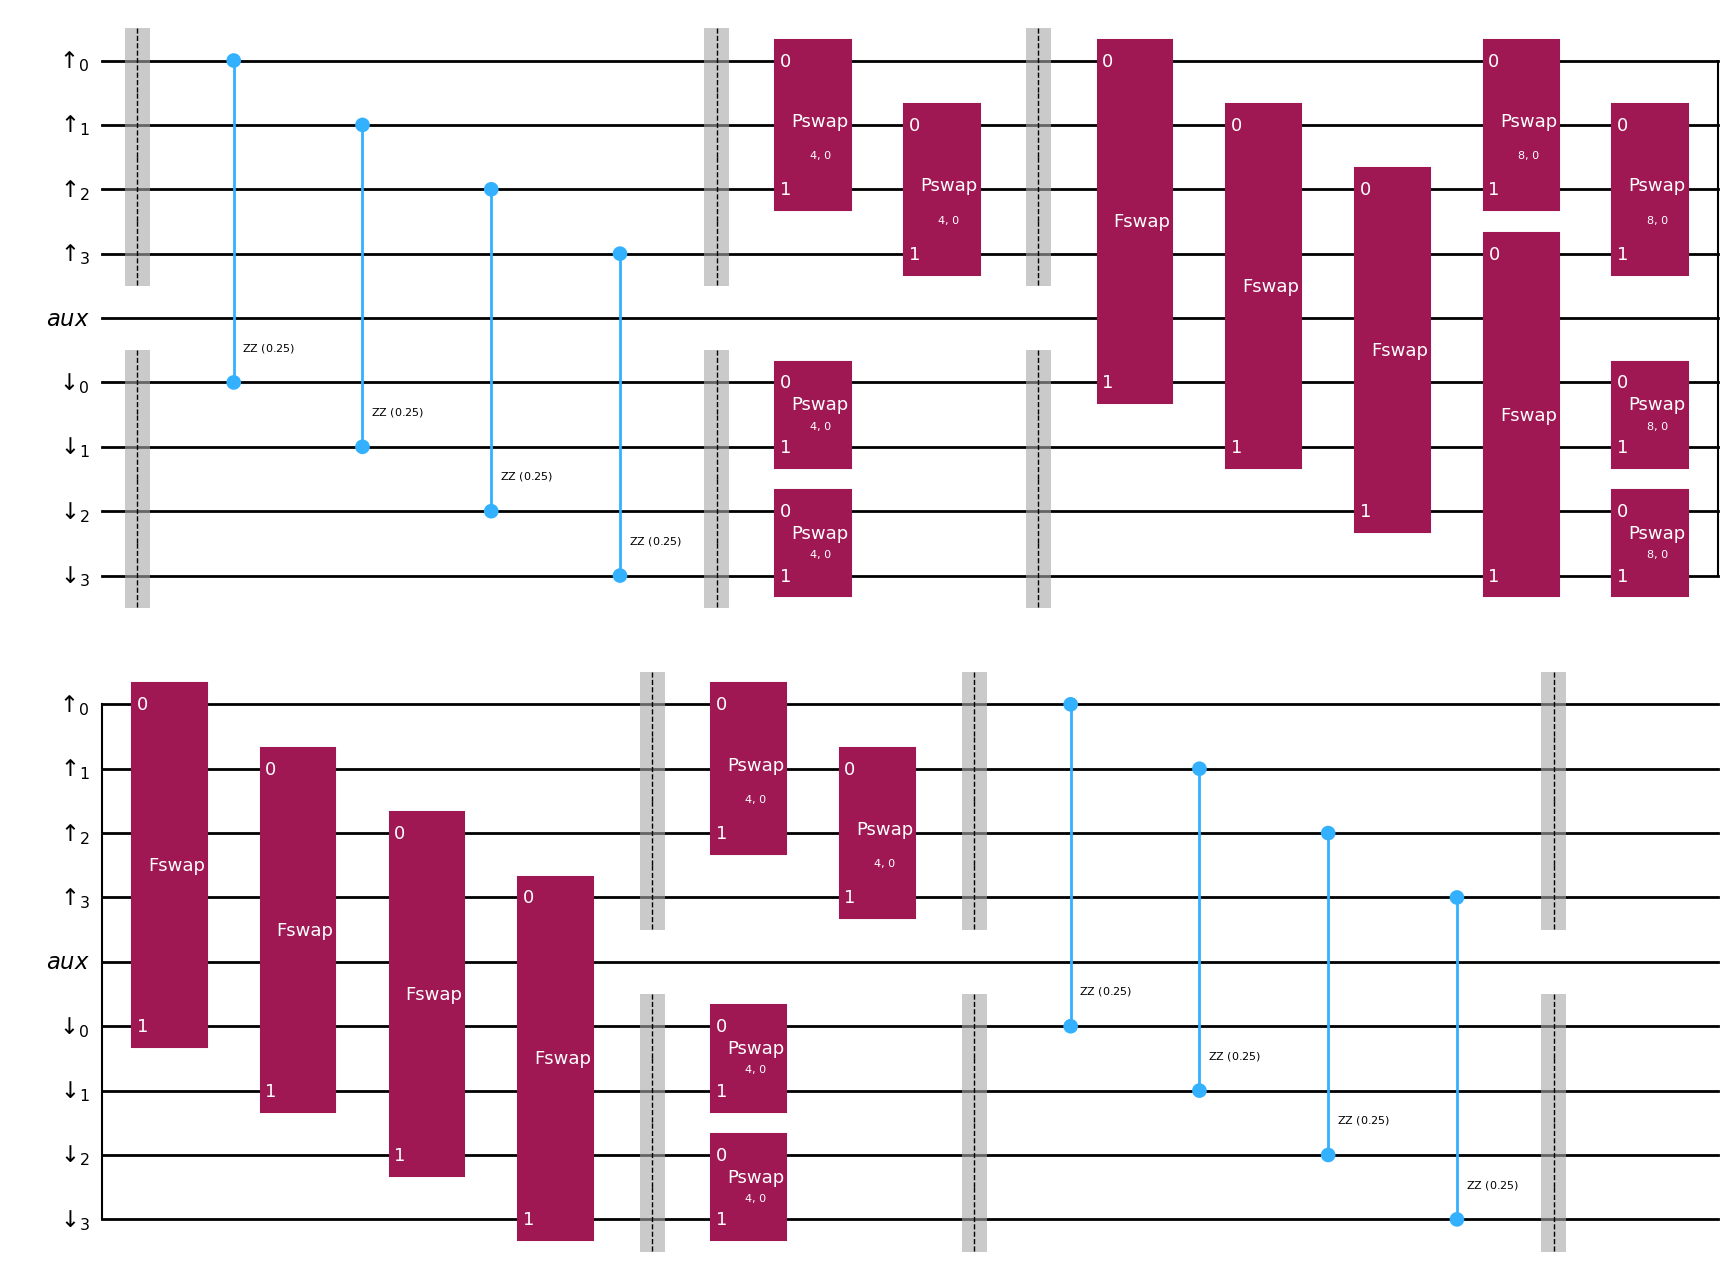

In [19]:
add_trotter_steps(single_step_circuit, spin_up, spin_down, None, num_sites, u, t, delta_t, 1)
single_step_circuit.draw("mpl")

### Mapping

In [20]:
backend = WMIBackendGrid()

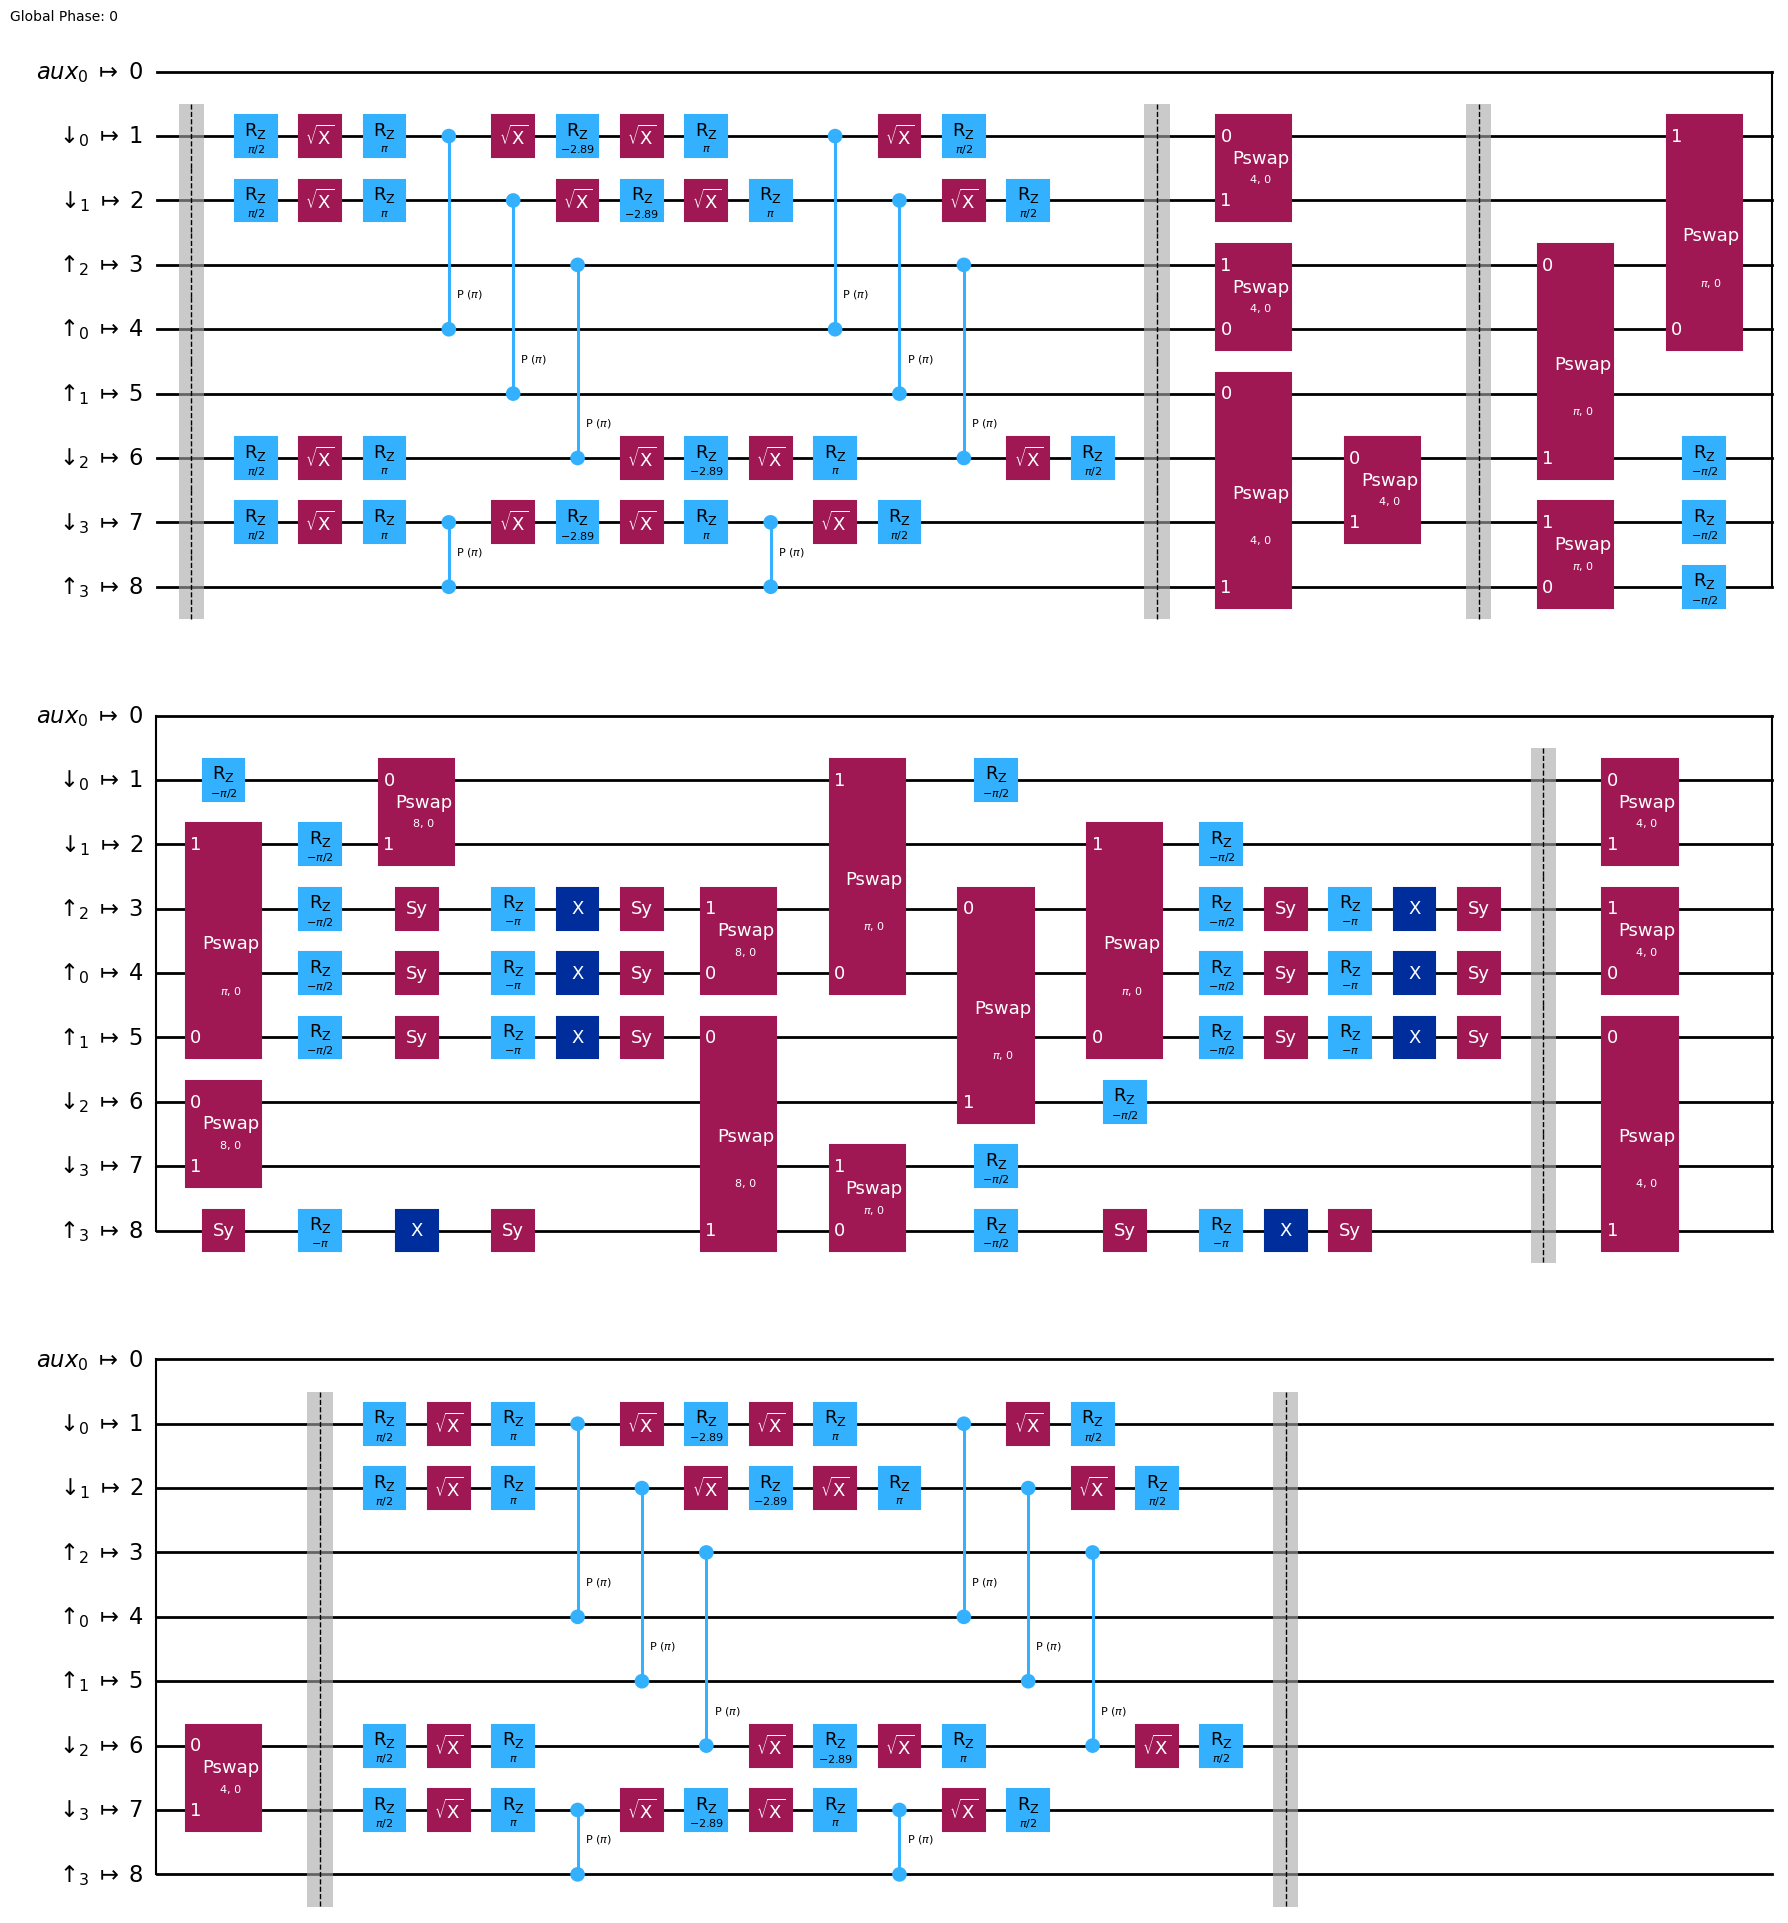

In [21]:
initial_layout = Layout({
    spin_up[0]:   0,
    spin_down[0]: 1,
    spin_up[1]:   2,
    spin_down[1]: 5,
    spin_up[2]:   3,
    spin_down[2]: 6,
    spin_up[3]:   7,
    spin_down[3]: 8,
})

# Transpile to WMI hardware
transpiled_single_step_circuit = transpile(
    single_step_circuit,
    backend=backend,
    optimization_level=3,
    #initial_layout=initial_layout
)
#transpiled_single_step_circuit.measure_active()
transpiled_single_step_circuit.draw("mpl")

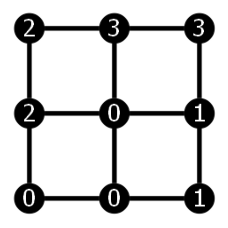

In [22]:
qubit_coordinates = [[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2], [2, 0], [2, 1], [2, 2]]
plot_circuit_layout(transpiled_single_step_circuit, backend, view="virtual", qubit_coordinates=qubit_coordinates)

Check if the transpiled circuit is equivalent to the original circuit (up to a global phase):

In [23]:
from qiskit.quantum_info import Statevector
Statevector.from_instruction(transpiled_single_step_circuit).equiv(Statevector.from_instruction(single_step_circuit))

True

# Control-free implementation

In [24]:
spin_up = QuantumRegister(num_sites, '↑')
spin_down = QuantumRegister(num_sites, '↓')
aux = QuantumRegister(1, "aux")
ctrl_free_circuit = QuantumCircuit(aux, spin_up, spin_down)

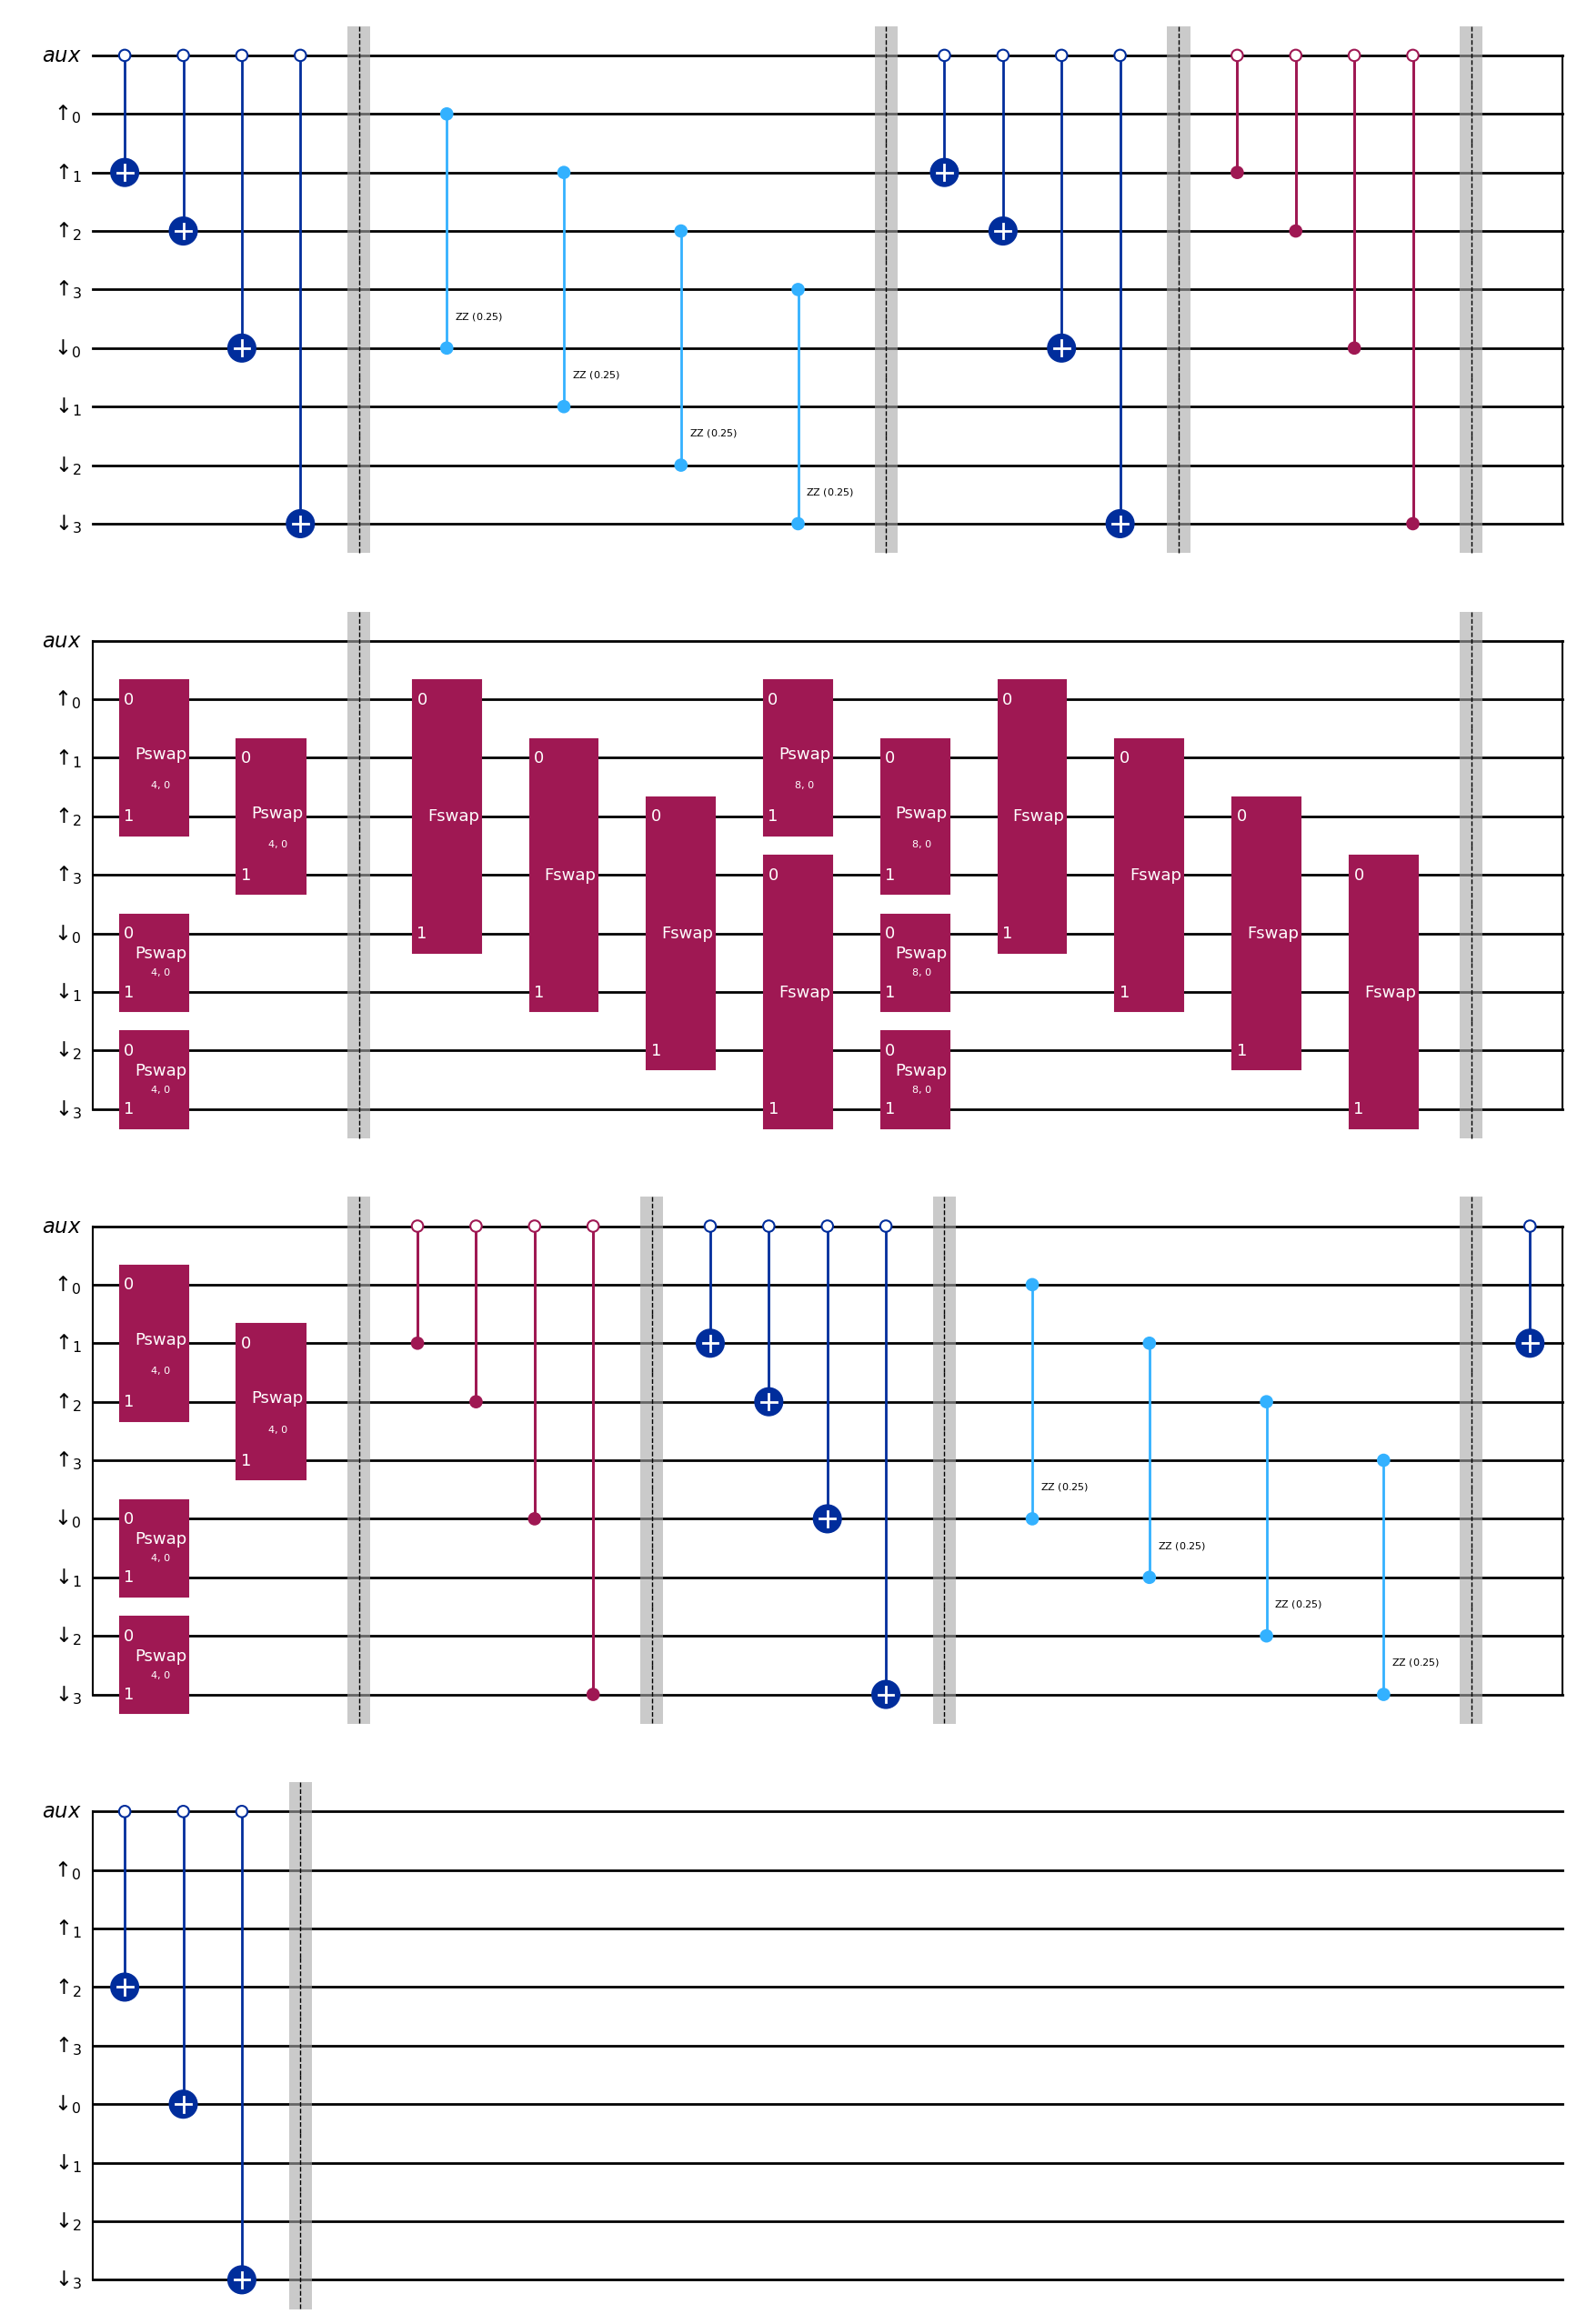

In [25]:
add_trotter_steps(ctrl_free_circuit, spin_up, spin_down, aux, num_sites, u, t, delta_t, 1, True, True)
ctrl_free_circuit.draw("mpl")

### Mapping

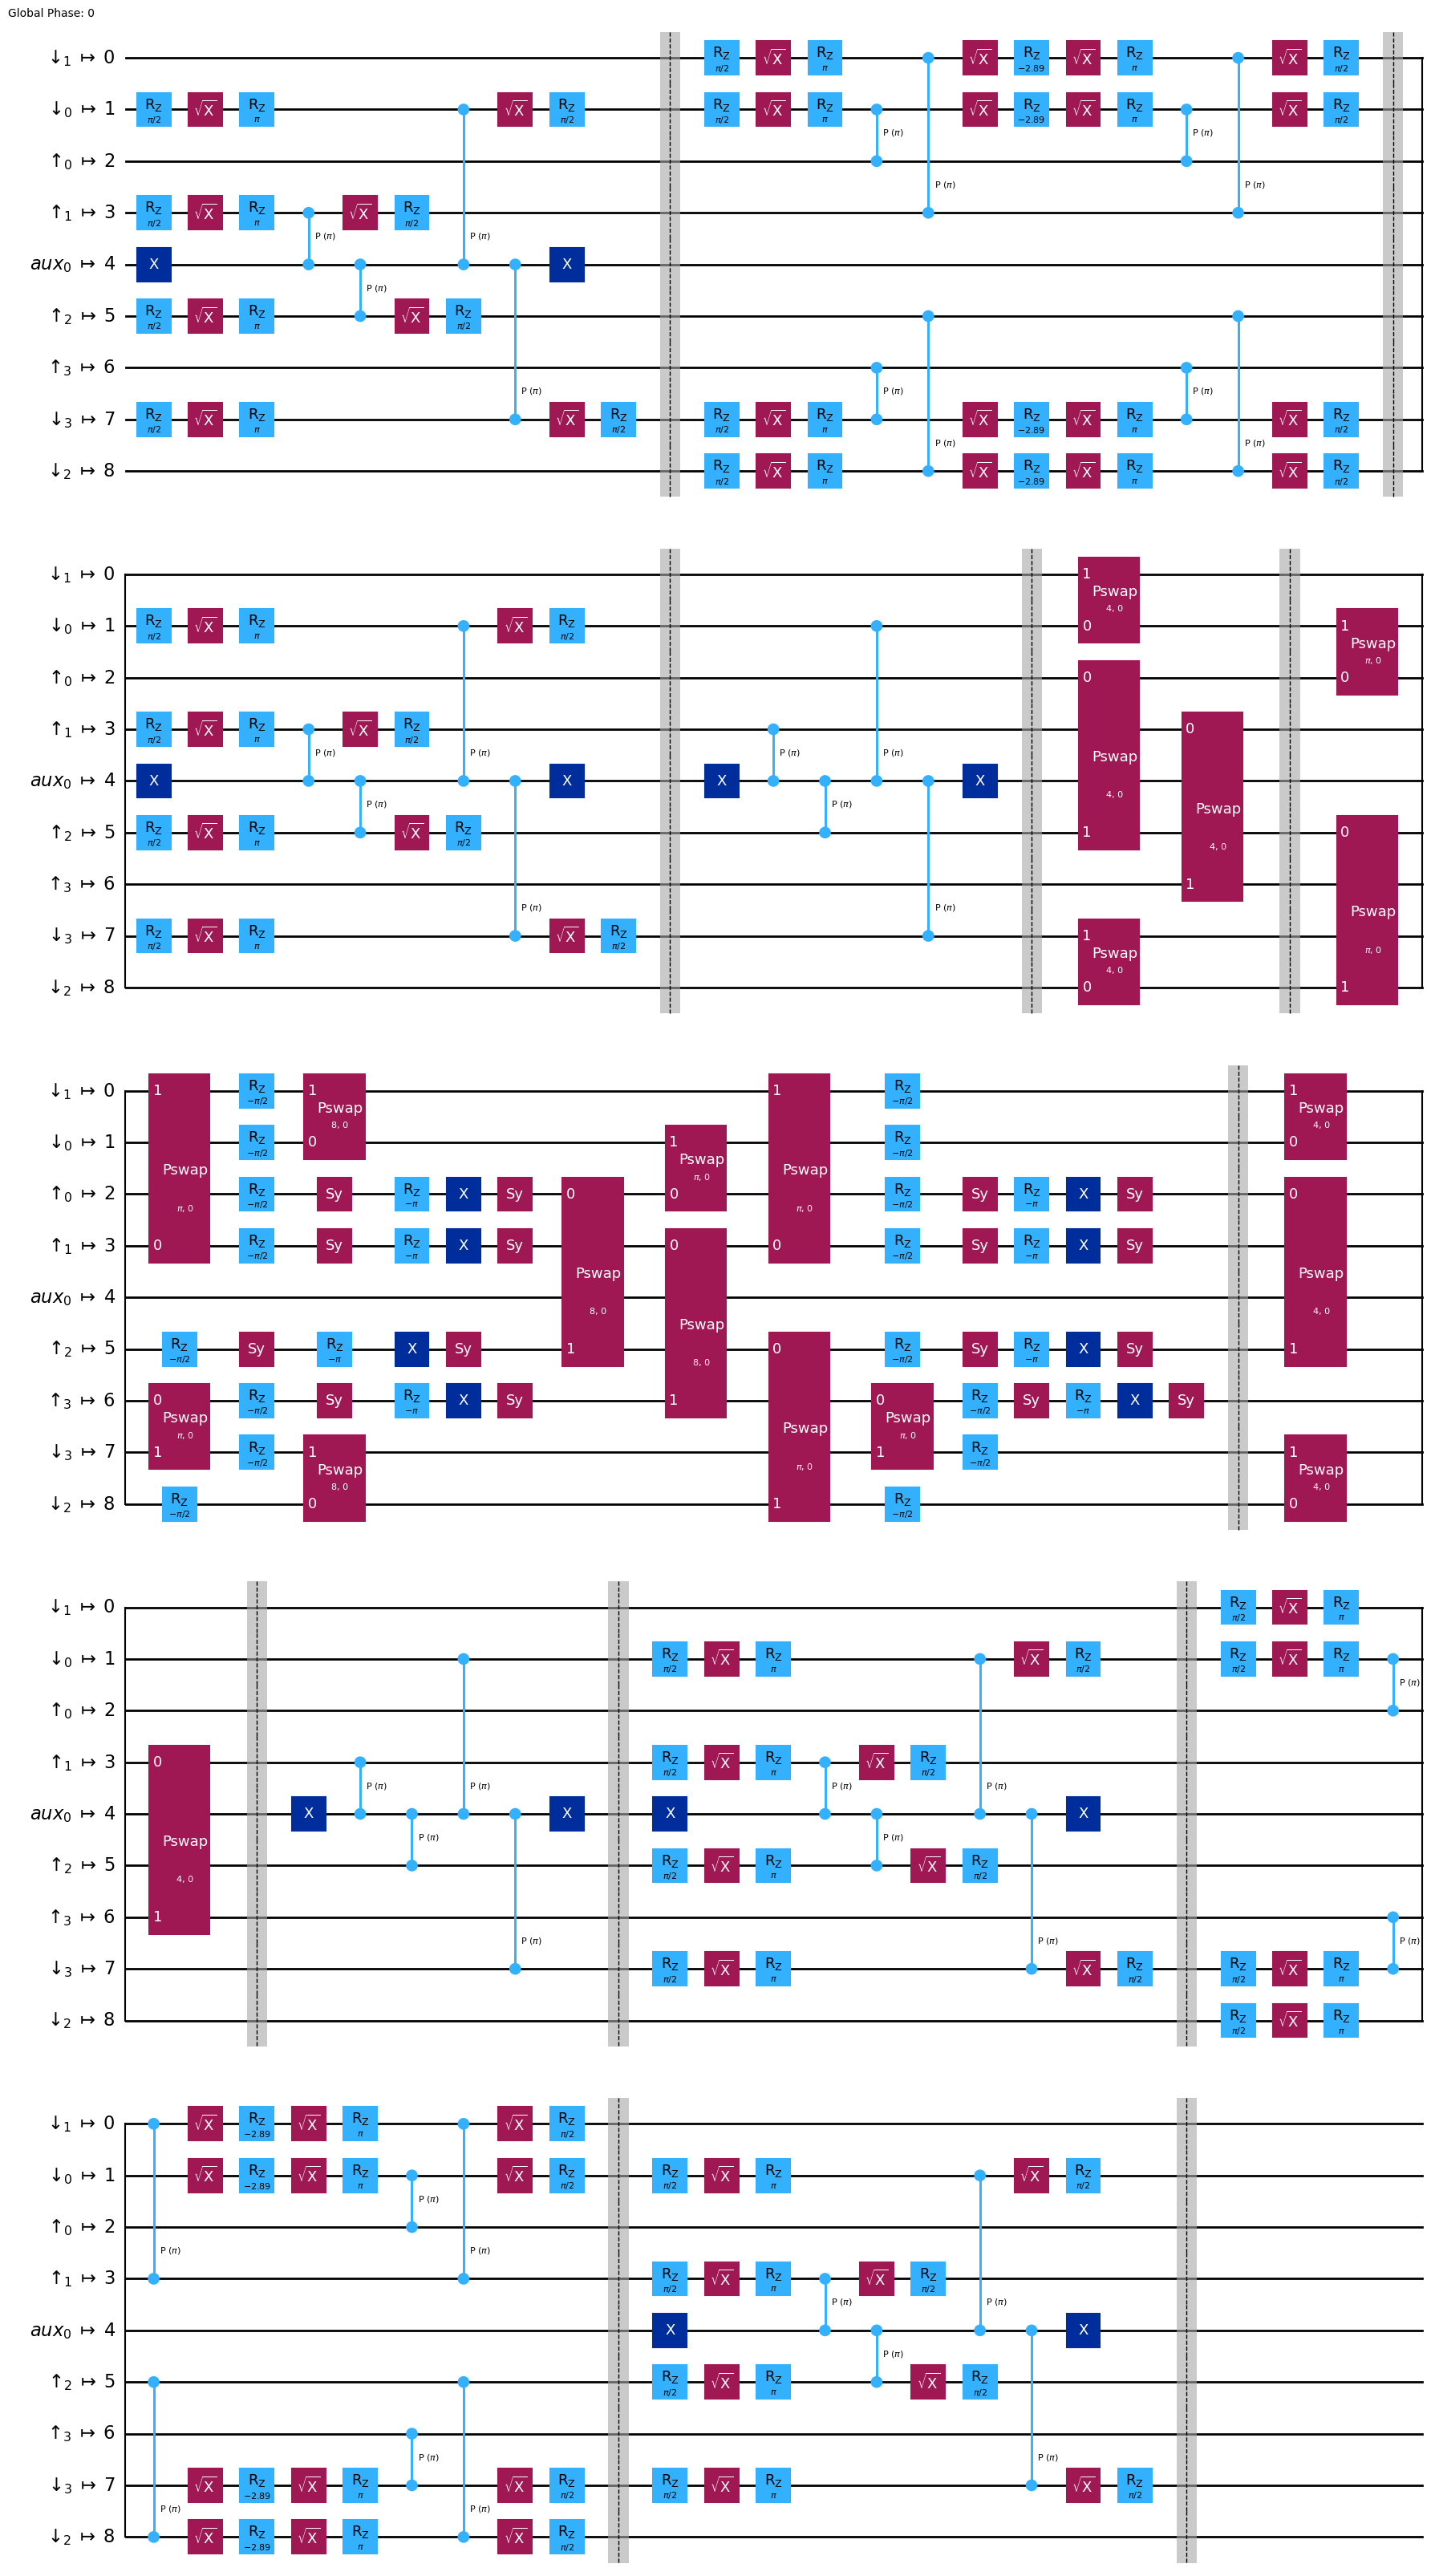

In [26]:
# Transpile to WMI hardware
transpiled_ctrl_free_circuit = transpile(
    ctrl_free_circuit,
    backend=backend,
    optimization_level=3,
    #initial_layout=initial_layout
)
#transpiled_ctrl_free_circuit.measure_active()
transpiled_ctrl_free_circuit.draw("mpl")

In [27]:
Statevector.from_instruction(transpiled_ctrl_free_circuit).equiv(Statevector.from_instruction(ctrl_free_circuit))

True

In [28]:
num_trotter_steps = [1] + [10*x for x in range(1, 31)]
error_list = []
circ_depth_list = []
circ_depht_no_rz_list = []
ops_count_list = []
for n in num_trotter_steps:
    ###########################
    # Calculate Trotter error 
    ###########################
    spin_up = QuantumRegister(num_sites, '↑')
    spin_down = QuantumRegister(num_sites, '↓')
    trotter_circuit = QuantumCircuit(spin_up, spin_down)
    add_trotter_steps(trotter_circuit, spin_up, spin_down, None, 4, u, t, delta_t, n, False, False)
    trotter_matrix = circuit2matrix(trotter_circuit, keep_qiskit_ordering=False)
    error = np.linalg.norm(ref_U_matrix - trotter_matrix, 2)
    error_list.append(error)
    ###########################
    # Calculate Circuit depth 
    ###########################
    spin_up = QuantumRegister(num_sites, '↑')
    spin_down = QuantumRegister(num_sites, '↓')
    aux = QuantumRegister(1, 'aux')
    ctrl_free_circuit = QuantumCircuit(spin_up, aux, spin_down)
    add_trotter_steps(ctrl_free_circuit, spin_up, spin_down, aux, num_sites, u, t, delta_t, n, True, False)
    transpiled_trotter_circuit = transpile(
        ctrl_free_circuit,
        backend=backend,
        optimization_level=3,
    )
    circ_depth = transpiled_trotter_circuit.depth()
    circ_depth_no_rz = compute_depth_no_rz(transpiled_trotter_circuit)
    ops_count = transpiled_trotter_circuit.count_ops()
    print("n: " + str(n) + "\t eror: " + str(error) + "\t depth: " + str(circ_depth) + "\t depth w/o rz: " + str(circ_depth_no_rz))
    circ_depth_list.append(circ_depth)
    circ_depht_no_rz_list.append(circ_depth_no_rz)
    ops_count_list.append(ops_count)

n: 1	 eror: 1.8302214916338229	 depth: 58	 depth w/o rz: 43
n: 10	 eror: 0.3333359943691388	 depth: 535	 depth w/o rz: 412
n: 20	 eror: 0.08160573988943248	 depth: 1065	 depth w/o rz: 822
n: 30	 eror: 0.036107406489950616	 depth: 1595	 depth w/o rz: 1232
n: 40	 eror: 0.02027782954886777	 depth: 2125	 depth w/o rz: 1642
n: 50	 eror: 0.012968077820571586	 depth: 2655	 depth w/o rz: 2052
n: 60	 eror: 0.009001923401177137	 depth: 3185	 depth w/o rz: 2462
n: 70	 eror: 0.006612021405195401	 depth: 3715	 depth w/o rz: 2872
n: 80	 eror: 0.005061514511719892	 depth: 4245	 depth w/o rz: 3282
n: 90	 eror: 0.003998779789761211	 depth: 4775	 depth w/o rz: 3692
n: 100	 eror: 0.003238755637664855	 depth: 5305	 depth w/o rz: 4102
n: 110	 eror: 0.002676500947001084	 depth: 5835	 depth w/o rz: 4512
n: 120	 eror: 0.0022489041475826908	 depth: 6365	 depth w/o rz: 4922
n: 130	 eror: 0.0019161596108201282	 depth: 6895	 depth w/o rz: 5332
n: 140	 eror: 0.0016521534044418287	 depth: 7425	 depth w/o rz: 5742
n

[]

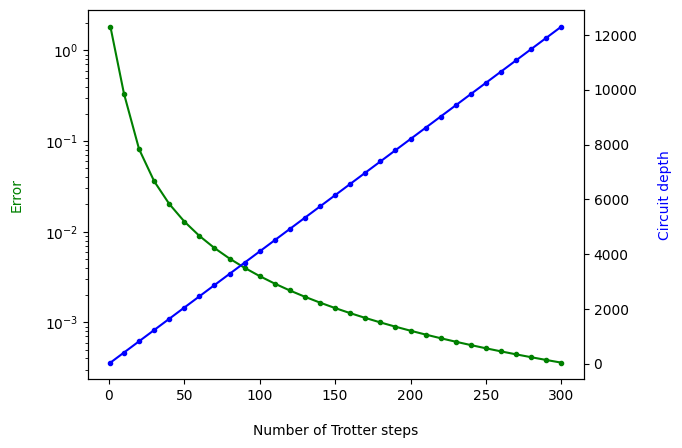

In [29]:
from matplotlib import pyplot as plt

x = num_trotter_steps
y1 = error_list
y2 = circ_depht_no_rz_list

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y1, '-g.')
ax2.plot(x, y2, '-b.')

ax1.set_yscale("log",base=10)

ax1.set_xlabel('Number of Trotter steps', labelpad = 15)
ax1.set_ylabel('Error', color='g', labelpad = 15)
ax2.set_ylabel('Circuit depth', color='b', labelpad = 15)


plt.plot()

### Shifted Hamiltonian

In [30]:
λ, v = np.linalg.eigh(ref_H_matrix)
λ = λ.real
λ_min = λ.min()
λ_max = λ.max()

η = 0.05
c1 = (np.pi/2 - 2*η) / (λ_max - λ_min)
c2 = η - c1 * λ_min

H_sh = c1*ref_H_matrix + c2*np.eye(ref_H_matrix.shape[0])
U_sh = scipy.linalg.expm(-1j*delta_t*H_sh)
V_sh = scipy.linalg.block_diag(U_sh.conjugate().transpose(), U_sh)

In [31]:
spin_up = QuantumRegister(num_sites, '↑')
spin_down = QuantumRegister(num_sites, '↓')
aux = QuantumRegister(1, 'aux')
shifted_trotter_circuit = QuantumCircuit(aux, spin_up, spin_down)
tau = delta_t*c1
shifted_trotter_circuit.rz(-2*c2, aux[0])
add_trotter_steps(shifted_trotter_circuit, spin_up, spin_down, aux, 4, u, t, tau, 300, True, False)
shifted_trotter_matrix = circuit2matrix(shifted_trotter_circuit, keep_qiskit_ordering=False)

In [32]:
error = np.linalg.norm(V_sh - shifted_trotter_matrix, 2)
print(error)

3.695868517164311e-08


In [33]:
# Transpile to WMI hardware
transpiled_shifted_trotter_circuit = transpile(
    shifted_trotter_circuit,
    backend=backend,
    optimization_level=3,
    #initial_layout=initial_layout
)
#transpiled_shifted_trotter_circuit.measure_active()
#transpiled_shifted_trotter_circuit.draw("mpl")

In [34]:
Statevector.from_instruction(transpiled_shifted_trotter_circuit).equiv(Statevector.from_instruction(shifted_trotter_circuit))

True